<a href="https://colab.research.google.com/github/bt22dr/PRML/blob/master/PRML_chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Linear Models for Regression

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
import copy
import math
import matplotlib.pyplot as plt

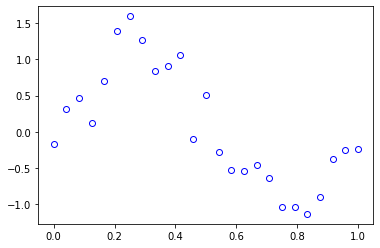

In [2]:
# 참고: https://github.com/ctgk/PRML

def sinusoidal(x):
  return tf.math.sin(2 * math.pi * x)

def linear(x):
  return -0.3 + 0.5 * x

def cubic(x):
  return x * (x - 5) * (x + 5)  

def create_toy_data(func, sample_size, std, domain=[0.0, 1.0]):
  x = tf.cast(tf.linspace(domain[0], domain[1], sample_size), tf.float64)
  x = tf.random.shuffle(x)
  t = func(x) + tf.random.normal(x.shape, stddev=std, dtype=tf.float64)
  return x, t

x, y = create_toy_data(sinusoidal, 25, 0.25)
plt.plot(x, y, 'bo', markerfacecolor='none')

## 3.1. Linear Basis Function Models

In [3]:
def polynomial_basis_functions(x, M):
  X = []
  for i in range(M):
    X.append(tf.math.pow(x, i))
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

print(polynomial_basis_functions(0.5, 4))
print(polynomial_basis_functions([-0.5, 0.0, 0.5], 6))

tf.Tensor([1.    0.5   0.25  0.125], shape=(4,), dtype=float64)
tf.Tensor(
[[ 1.      -0.5      0.25    -0.125    0.0625  -0.03125]
 [ 1.       0.       0.       0.       0.       0.     ]
 [ 1.       0.5      0.25     0.125    0.0625   0.03125]], shape=(3, 6), dtype=float64)


In [4]:
def gaussian_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.exp(-0.5 * tf.math.pow(tf.subtract(x, m), 2) / s**2)) # 식 3.4
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(gaussian_basis_functions(0.5, mu, s))
print(gaussian_basis_functions([-0.5, 0.0, 0.5], mu, s).shape)

tf.Tensor(
[0.00000000e+00 5.31107191e-27 2.28973489e-11 1.11090122e-02
 6.06530488e-01 3.72665318e-06], shape=(6,), dtype=float64)
(3, 6)


In [5]:
def sigmoidal_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.sigmoid(tf.subtract(x, m) / s)) # 식 3.5
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(sigmoidal_basis_functions(0.5, mu, s))
print(sigmoidal_basis_functions([-0.5, 0.0, 0.5], mu, s).shape)

tf.Tensor([0.99999964 0.99998331 0.999089   0.95257413 0.26894137 0.00669285], shape=(6,), dtype=float64)
(3, 6)


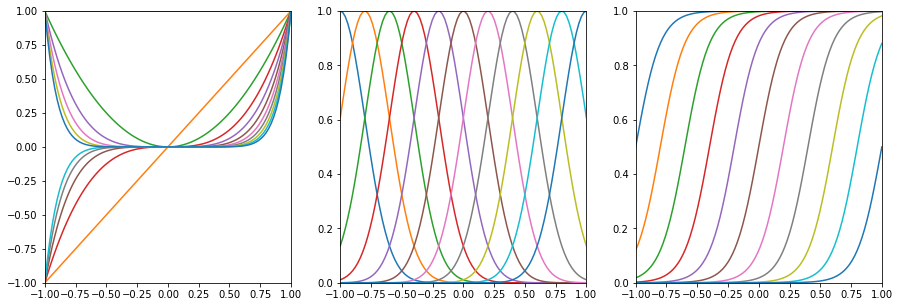

In [6]:
M = 11
mu = tf.linspace(-1.0, 1.0, M)
x = tf.linspace(-1.0, 1.0, 100)

X_polynomial = polynomial_basis_functions(x, M)
X_gaussian = gaussian_basis_functions(x, mu, 0.2)
X_sigmoidal = sigmoidal_basis_functions(x, mu, 0.1)

plt.figure(figsize=(15, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
  plt.subplot(1, 3, i + 1)
  for j in range(M):
    plt.plot(x, X[:, j])
  plt.xlim(-1,1); plt.ylim(tf.reduce_min(X).numpy(), tf.reduce_max(X).numpy())

### 3.1.1 Maximum likelihood and least squares

$$
\mathbf{w}_\text{ML} = (\Phi^T\Phi)^{-1}\Phi^T \mathsf{\bf{t}}
$$

In [7]:
x, t = create_toy_data(sinusoidal, 10, 0.2)
M = 2
design_mat = polynomial_basis_functions(x, M)
pseudo_inverse = tf.linalg.matmul(
    tf.linalg.inv(tf.linalg.matmul(tf.transpose(design_mat), design_mat)),
    tf.transpose(design_mat)) # 식 3.17

# w_ML = np.linalg.pinv(design_mat) @ t
w_ML = tf.linalg.matvec(pseudo_inverse, t) # 식 3.15
beta_ML = 1. / tf.reduce_mean(
    tf.math.square(t - tf.linalg.matvec(design_mat, w_ML))) # 식 3.21
    
print(w_ML)
print(1./beta_ML)

tf.Tensor([ 0.73650358 -1.27639289], shape=(2,), dtype=float64)
tf.Tensor(0.17918302941454753, shape=(), dtype=float64)


$$
w_0 = \bar{t} - \Sigma_{j=1}^{M-1} w_j \bar{\phi_{j}}
$$

In [0]:
t_bar = tf.reduce_mean(t)
phi_j_bar = tf.reduce_mean(design_mat, axis=0)
sigma_term = w_ML * phi_j_bar
eq_3_19 = t_bar - tf.reduce_sum(sigma_term[1:]) # 식 3.19

assert(abs(w_ML[0] - eq_3_19) < 1.0e-6)

In [0]:
class LinearRegression():
  def __init__(self):
    pass

  def train(self, X, t):
    pseudo_inverse = tf.linalg.matmul(
      tf.linalg.inv(tf.linalg.matmul(tf.transpose(X), X)),
      tf.transpose(X)) # 식 3.17
    self.w = tf.linalg.matvec(pseudo_inverse, t) # 식 3.15
    self.var = tf.reduce_mean(
        tf.math.square(t - tf.linalg.matvec(design_mat, self.w))) # 식 3.21
  
  def evaluate(self):
    pass

  def predict(self, X):
    return tf.linalg.matvec(X, self.w) # 식 3.3

In [0]:
x, t = create_toy_data(sinusoidal, 10, 0.25)

Ms = [1, 2, 4, 10]
models = []
for M in Ms:
  design_mat = polynomial_basis_functions(x, M)
  model = LinearRegression()
  model.train(design_mat, t)
  models.append(model)

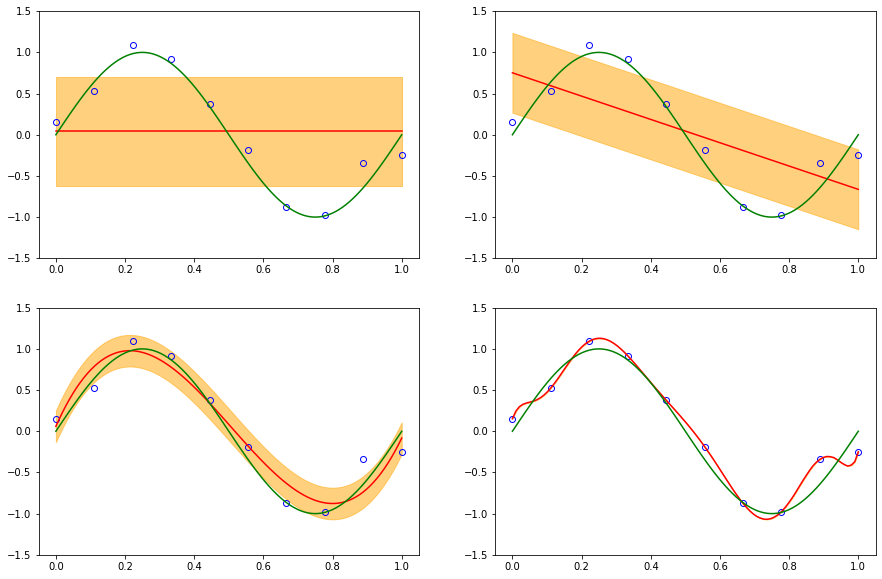

In [11]:
plt.figure(figsize=(15,10))
for i, model in enumerate(models):
  target_std = tf.sqrt(model.var)
  plot_x = tf.linspace(0.0, 1.0, 100)
  design_mat = polynomial_basis_functions(plot_x, len(model.w))
  plot_y = model.predict(design_mat)

  plt.subplot(2, 2, i + 1)
  plt.plot(x, t, 'bo', markerfacecolor='none')
  plt.plot(plot_x, plot_y, 'r')
  plt.fill_between(
    plot_x, plot_y - target_std, plot_y + target_std,
    color="orange", alpha=0.5)
  plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')
  plt.ylim(-1.5, 1.5)

### 3.1.4 Regularized least squares

$$
L = \frac{1}{2} \Sigma_{n=1}^{N} \{t_n - \textbf{w}^\text{T} \phi(\textbf{x}_n) \}^2 + \frac{\lambda}{2} \textbf{w}^\text{T}\textbf{w}
$$

$$
\textbf{w}_\text{reg} = (\lambda \textbf{I} + \mathbf{\Phi}^\text{T}\mathbf{\Phi})^{-1}\mathbf{\Phi}^\text{T} \mathsf{\bf{t}}
$$

In [0]:
class RidgeRegression():
  def __init__(self, lamb=1.e-3):
    self.lamb = lamb

  def train(self, X, t):
    lamb = self.lamb
    I = tf.eye(len(t), dtype=tf.float64)
    self.w = tf.linalg.matvec(
        tf.linalg.matmul(
            tf.linalg.inv(
                tf.add(lamb * I, tf.linalg.matmul(tf.transpose(X), X))), 
            tf.transpose(X)),
        t) # 식 3.28
  
  def evaluate(self):
    pass

  def predict(self, X):
    return tf.linalg.matvec(X, self.w)

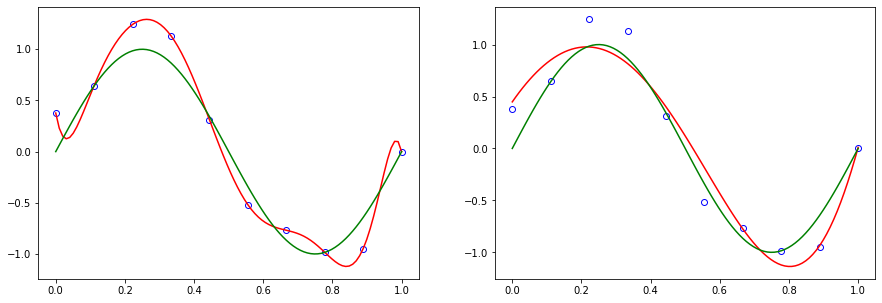

In [13]:
M = 10
x, t = create_toy_data(sinusoidal, 10, 0.2)
design_mat = polynomial_basis_functions(x, M)

linear = LinearRegression(); linear.train(design_mat, t)
ridge = RidgeRegression(); ridge.train(design_mat, t)
models = [linear, ridge]

plt.figure(figsize=(15,5))
for i, model in enumerate(models):
  plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
  design_mat = polynomial_basis_functions(plot_x, M)
  plot_y = model.predict(design_mat)

  plt.subplot(1, 2, i+1)
  plt.plot(x, t, 'bo', markerfacecolor='none')
  plt.plot(plot_x, plot_y, 'r')
  plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')

## 3.2. The Bias-Variance Decomposition

In [0]:
L = 100
M = 25
N = 25

D = []
for i in range(L):
  x, t = create_toy_data(sinusoidal, N, 0.25)
  D.append({'x':x, 't':t})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


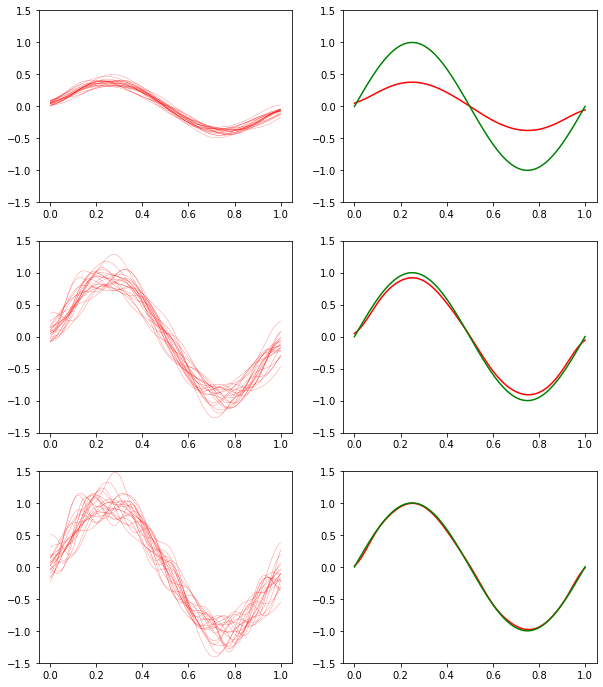

In [15]:
plt.figure(figsize=(10,12))
lamb_list = tf.cast(tf.math.exp([2.6, -0.31, -2.4]), tf.float64)
for i, lamb in enumerate(lamb_list):
  fits = []
  for l in range(L):
    x, t = D[l]['x'], D[l]['t']
    phi = gaussian_basis_functions(
        x, tf.cast(tf.linspace(0.0, 1.0, M), tf.float64), 0.05)

    model = RidgeRegression(lamb)
    model.train(phi, t)
    
    plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
    phi = gaussian_basis_functions(
        plot_x, tf.cast(tf.linspace(0.0, 1.0, M), tf.float64), 0.05)
    plot_y = model.predict(phi)
    fits.append(plot_y)

    if l <= 20:
      ax = plt.subplot(3, 2, i*2+1)
      ax.plot(plot_x, plot_y, 'r', linewidth=0.2)
      plt.ylim(-1.5,1.5)

  plt.subplot(3, 2, i*2+2)
  average_fits = tf.reduce_mean(tf.stack(fits), axis=0)
  plt.plot(plot_x, average_fits, 'r')
  plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')
  plt.ylim(-1.5,1.5)

## 3.3. Bayesian Linear Regression

In [0]:
import numpy as np

class Gaussian:
  def __init__(self, mu=None, var=None):
    self.mu = mu
    self.var = var
    if mu is not None:
      assert self.check_parameter_mu(mu), "mu in R"
      self.mu = tf.cast(mu, tf.float32)
    if var is not None:
      assert self.check_parameter_var(var), "var > 0 and var.shape == mu.shape"
      self.var = tf.cast(var, tf.float32)
    
  def check_support(self, x):
    if np.isscalar(x):
      return not isinstance(x, complex)
    else:
      return all([not isinstance(e, complex) for e in x])

  def check_parameter_mu(self, mu):
    if np.isscalar(mu):
      return not isinstance(mu, complex)
    else:
      return all([not isinstance(e, complex) for e in mu])
  
  def check_parameter_var(self, var):
    if np.isscalar(var):
      return var > 0
    else:
      return all([e > 0 for e in var]) and mu.shape == var.shape

  def mean(self):
    return self.mu
  
  def variance(self):
    return self.var

  def pdf(self, x):
    assert self.check_support(x), "x in R"
    mu = self.mu
    var = self.var
    x = tf.cast(x, tf.float32)

    d = tf.math.subtract(x, mu)
    return (tf.math.exp(-0.5 / var * d ** 2) / tf.math.sqrt(2 * np.pi * var))
  
  def mle(self, D):
    pass

In [0]:
class MultivariateGaussian:
  def __init__(self, mu=None, cov=None):
    self.mu = mu
    self.cov = cov
    if mu is not None and cov is not None:
      self.mu = tf.reshape(tf.cast(mu, tf.float64), shape=[-1, 1])
      self.D  = self.mu.shape[0]
      self.cov = tf.cast(cov, tf.float64)

  def mean(self):
    return tf.squeeze(self.mu)
  
  def covariance(self):
    return self.cov

  def pdf(self, x):
    mu = self.mu
    cov = self.cov
    
    x = tf.transpose(tf.cast(x, tf.float64))
    d = tf.math.subtract(x, mu)
    precision_mat = tf.linalg.inv(cov)
    return tf.squeeze(
      tf.linalg.diag_part(
        tf.math.exp(-0.5 * tf.matmul(
            tf.matmul(tf.transpose(d), precision_mat), d))
        / tf.math.sqrt(tf.linalg.det(cov))
        / tf.math.pow(tf.cast(2.0, tf.float64) * math.pi, 0.5 * self.D)))

  def mle(self, D):
    N = len(D)
    sample_mean = tf.reduce_mean(D, axis=0) # (식 2.122)
    self.mu = tf.reshape(sample_mean, shape=[-1, 1])
    D = tf.transpose(D)
    d = tf.subtract(D, self.mu)
    self.cov = (1/(N-1) * tf.matmul(d, tf.transpose(d))) # (식 2.125)

    return self.mean(), self.covariance()

  # TODO: np 제거
  def sample(self, sample_size):
    import numpy as np
    mu = tf.squeeze(self.mu)
    cov = self.cov
    return np.random.multivariate_normal(mu, cov, sample_size)

In [0]:
class BayesianRegression():
  def __init__(self, prior, beta=25.0):
    self.beta = beta
    self.prior = prior
    self.posterior = copy.deepcopy(prior)

  def train(self, X, t):
    self.prior = copy.deepcopy(self.posterior)

    prior_mean = self.prior.mean()
    prior_precision = tf.linalg.inv(self.prior.covariance())

    posterior_precision = tf.math.add(prior_precision,
      beta * tf.linalg.matmul(tf.transpose(X), X)) # 식 3,51

    posterior_covariance = tf.linalg.inv(posterior_precision)
    second_term = tf.math.add(
        tf.linalg.matvec(prior_precision, prior_mean), 
        beta * tf.linalg.matvec(tf.transpose(X), t))
    posterior_mean = tf.linalg.matvec(posterior_covariance, second_term)

    self.posterior = MultivariateGaussian(posterior_mean, posterior_covariance)
  
  def evaluate(self):
    pass

  def predict(self, X):
    return tf.linalg.matvec(X, self.posterior.mean) # 식 3.3
  
  # 식 3.3, 식 3.8
  def likelihood(self, phi, t, w):
    y_of_xw = tf.linalg.matvec(phi, tf.cast(w, tf.float64))
    beta = self.beta
    mean = y_of_xw
    cov = 1.0 / beta
    dist = Gaussian(mean, cov)
    return dist.pdf(t[0:1])

In [0]:
a0, a1 = -0.3, 0.5
alpha, beta = 2.0, 25.0
N = 20

prior = MultivariateGaussian([0.0, 0.0], (1.0/alpha)*tf.eye(2))
model = BayesianRegression(prior)

def linear(x):
  return a0 + a1 * x

x, t = create_toy_data(linear, N, tf.sqrt(1.0/beta).numpy(), [-1.0, 1.0])
x_plot = tf.linspace(-1.0, 1.0, 100)

In [0]:
M = 2
X = polynomial_basis_functions(x, M)
X_plot = polynomial_basis_functions(x_plot, M)

In [0]:
u1 = tf.linspace(-1.0, 1.0, num=100)
u2 = tf.linspace(-1.0, 1.0, num=100)
u_grid = tf.stack(tf.meshgrid(u1, u2), axis=-1)
u_grid = tf.reshape(u_grid, [-1, 2])

In [0]:
def train_bayesian_regression(model, data_range=None):
  if data_range is not None:
    begin, end = data_range
    model.train(X[begin:end], t[begin:end])

  posterior = model.posterior
  q0 = posterior.pdf(u_grid)
  
  plt.figure(figsize=(7,2))

  if data_range is not None:
    ax = plt.subplot(1, 3, 1)
    likelihood_list = []
    for i, mu in enumerate(u_grid):
      likelihood_list.append(model.likelihood(X[end-1:end], t[end-1:end], mu))
    plt.hexbin(u_grid[:,0], u_grid[:,1], C=likelihood_list, cmap='jet')

  ax = plt.subplot(1, 3, 2)
  plt.hexbin(u_grid[:,0], u_grid[:,1], C=q0.numpy(), cmap='jet')
  plt.scatter(a0, a1, c='w', s=100, marker="+")
  plt.gca().set_aspect('equal')
  plt.xlim([-1, 1])
  plt.ylim([-1, 1])

  ax = plt.subplot(1, 3, 3)
  ws = posterior.sample(6)
  Y_plot = tf.linalg.matmul(X_plot, tf.transpose(ws))
  for i in range(6):
    plt.plot(x_plot, Y_plot[:,i], c="r")
  if data_range is not None:
    plt.plot(x[:end], t[:end], 'bo', markerfacecolor='none')
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  plt.gca().set_aspect('equal')

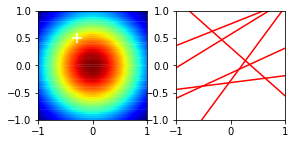

In [23]:
train_bayesian_regression(model)

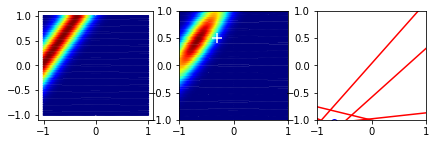

In [24]:
train_bayesian_regression(model, [0,1])

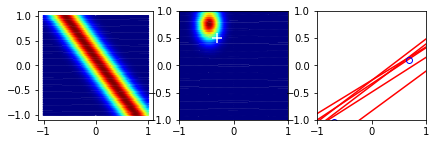

In [25]:
train_bayesian_regression(model, [1,2])

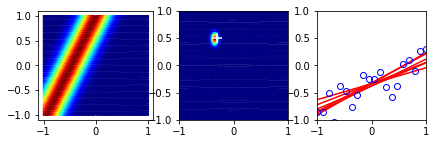

In [26]:
train_bayesian_regression(model, [2,20])